## Real Estate Market Project

(Supervised Learning)

### 01. Data science project implementation
An old real estate agency located in Seattle, Washington, has been operating in the city for a long time and, in search of new market trends, wants to offer more services in addition to the traditional ones, such as renting, selling or buying real estate.

One new service that is proving lucrative is real estate pricing, but there aren't enough people to work with. As the process is time-consuming, clients are looking for other companies and money is being lost.

The goal of this project is to provide another solution on how to price properties more efficiently. For this, a dataset with data from a few years has been provided, in which all the properties have already been analyzed and the pricing has been done personally.

To complete this project all the data was studied and maching learning models was created to do the predictions. <br />
All models was used using pyspark with Spark's MLlib. <br />
The data used is in the file "seeds_dataset.csv" in csv format and, after being received, was processed for later use by ML. 

In [0]:
# You may need to install the following libraries:
# pip install catboost
# pip install xgboost
# pip install basemap
# pip install basemap-data-hires

In [0]:
# Import related packages
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Feature Selection
from pyspark.ml.feature import StandardScaler as StandardScaler_01
from sklearn.preprocessing import StandardScaler as StandardScaler_02
from pyspark.ml.feature import VectorAssembler
from sklearn.feature_selection import SelectFdr, f_regression, chi2

# Sklearn library
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Build the Model
from pyspark.ml.regression import LinearRegression as LinearRegression_01
from sklearn.linear_model import LinearRegression as LinearRegression_02
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import catboost as ctb
import xgboost as xgb

# Maps
from mpl_toolkits.basemap import Basemap

# Start spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('real_state').getOrCreate()


### 02. Sourcing Data

In [0]:
# 02.1 Loading data
dataset_all = spark.read.csv('/FileStore/tables/house_info.csv', header=True, inferSchema=True)

dataset_all.columns # R:['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

dataset_all.printSchema()
dataset_all.show(3)

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)

+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------

### 03. Exploratory Data Analysis and Data Cleaning

In [0]:
# 03.1 Setting up the data
filtered_columns_01 = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'] # First filter to remove elements that is not needed as id, date

dataset_filter_01 = dataset_all.select(filtered_columns_01)
df = dataset_filter_01.toPandas()

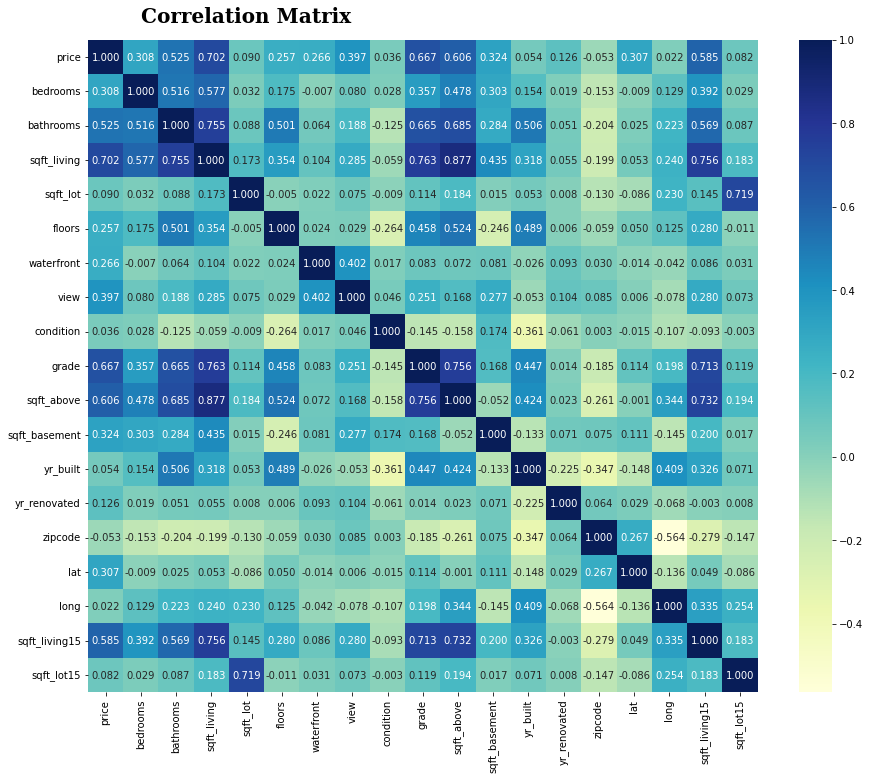

In [0]:
# 03.2 Correlation Matrix
fig = plt.figure(figsize=(15,12))
gs = fig.add_gridspec(1,1)
ax0 = fig.add_subplot(gs[0,0])
ax0.text(1.5,-0.5,"Correlation Matrix",fontsize=20, fontweight='bold', fontfamily='serif', color="#000000")

sns.heatmap(df.corr(),fmt=".3f",annot=True,cmap='YlGnBu')
plt.show()

The columns that have the weakest correlation with the price (0 to +-0.19 -> Very weak) are 'sqft_lot', 'condition', 'yr_built', yr_renovated', 'zipcode', 'long' 'sqft_lot15'. <br/>

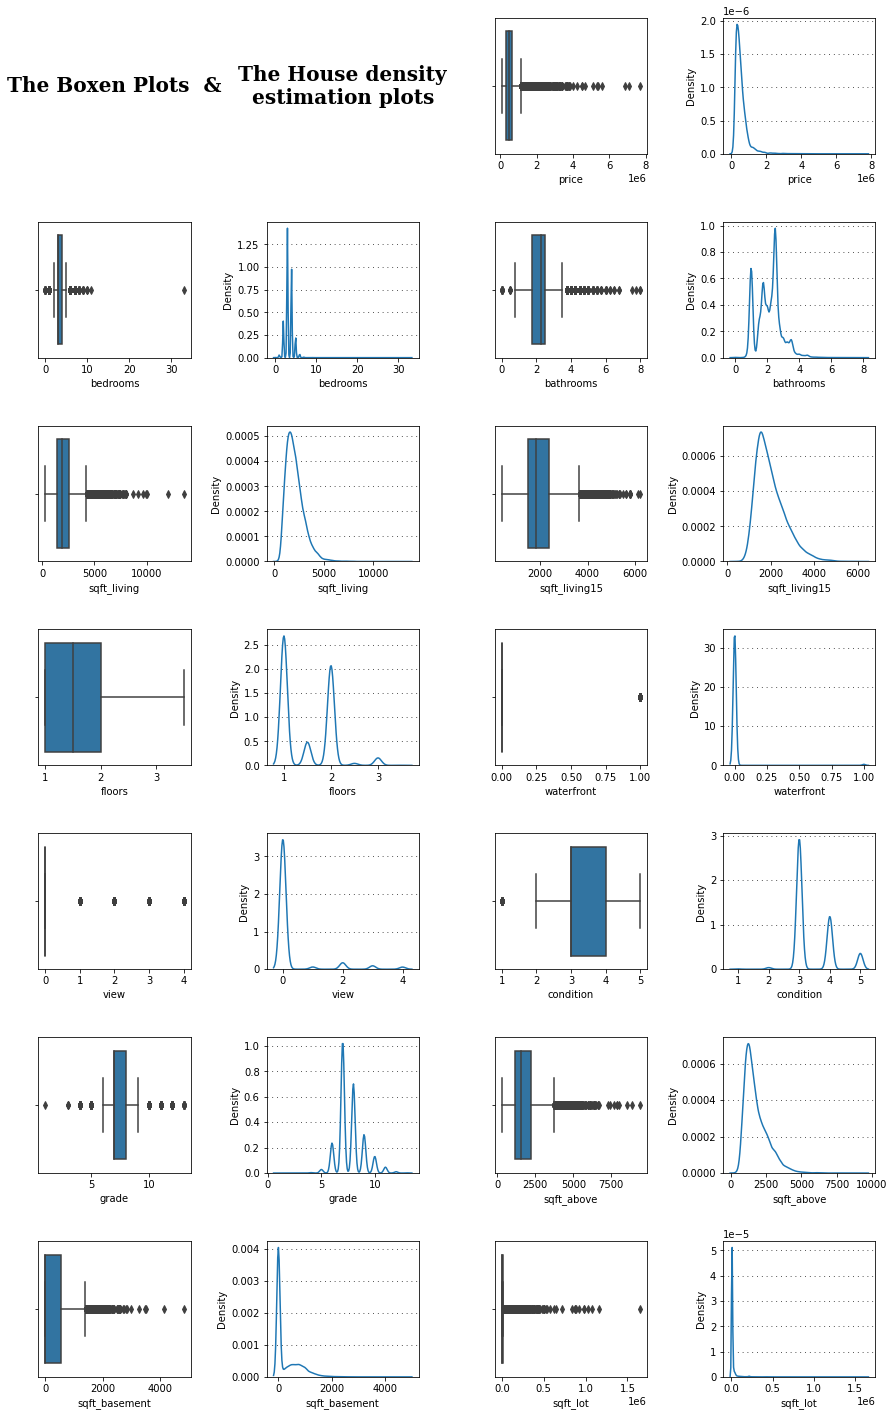

In [0]:
# 03.3 Plots
fig = plt.figure(figsize=(15,25))
gs = fig.add_gridspec(7,4)
gs.update(wspace=0.5, hspace=0.5)

ax0 = fig.add_subplot(gs[0,0])
ay0 = fig.add_subplot(gs[0,1])

ax1 = fig.add_subplot(gs[0,2]) # price
ay1 = fig.add_subplot(gs[0,3]) # price

ax2 = fig.add_subplot(gs[1,0]) # bedrooms
ay2 = fig.add_subplot(gs[1,1]) # bedrooms

ax3 = fig.add_subplot(gs[1,2]) # bathrooms
ay3 = fig.add_subplot(gs[1,3]) # bathrooms

ax4 = fig.add_subplot(gs[2,0]) # sqft_living
ay4 = fig.add_subplot(gs[2,1]) # sqft_living

ax5 = fig.add_subplot(gs[2,2]) # sqft_living15
ay5 = fig.add_subplot(gs[2,3]) # sqft_living15

ax6 = fig.add_subplot(gs[3,0]) # floors
ay6 = fig.add_subplot(gs[3,1]) # floors

ax7 = fig.add_subplot(gs[3,2]) # waterfront
ay7 = fig.add_subplot(gs[3,3]) # waterfront

ax8 = fig.add_subplot(gs[4,0]) # view
ay8 = fig.add_subplot(gs[4,1]) # view

ax9 = fig.add_subplot(gs[4,2]) # condition
ay9 = fig.add_subplot(gs[4,3]) # condition

ax10 = fig.add_subplot(gs[5,0]) # grade
ay10 = fig.add_subplot(gs[5,1]) # grade

ax11 = fig.add_subplot(gs[5,2]) # sqft_above
ay11 = fig.add_subplot(gs[5,3]) # sqft_above

ax12 = fig.add_subplot(gs[6,0]) # sqft_basement
ay12 = fig.add_subplot(gs[6,1]) # sqft_basement

ax13 = fig.add_subplot(gs[6,2]) # sqft_lot
ay13 = fig.add_subplot(gs[6,3]) # sqft_lot


ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.grid(False) 
ax0.text(0.5,0.5,
         'The Boxen Plots  &',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=20, fontweight='bold',
         fontfamily='serif',
         color="#000000")
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)

ay0.set_xticklabels([])
ay0.set_yticklabels([])
ay0.grid(False) 
ay0.text(0.5,0.5,
         'The House density\nestimation plots',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=20, fontweight='bold',
         fontfamily='serif',
         color="#000000")
ay0.spines["bottom"].set_visible(False)
ay0.spines["left"].set_visible(False)
ay0.spines["top"].set_visible(False)
ay0.spines["right"].set_visible(False)
ay0.tick_params(left=False, bottom=False)

ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxplot(ax=ax1, data=df, x='price')
ay1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ay1, data=df, x='price')

ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxplot(ax=ax2, data=df, x='bedrooms')
ay2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ay2, data=df, x='bedrooms')

ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxplot(ax=ax3, data=df, x='bathrooms')
ay3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ay3, data=df, x='bathrooms')

ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxplot(ax=ax4, data=df, x='sqft_living')
ay4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ay4, data=df, x='sqft_living')

ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxplot(ax=ax5, data=df, x='sqft_living15')
ay5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ay5, data=df, x='sqft_living15')

ax6.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxplot(ax=ax6, data=df, x='floors')
ay6.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ay6, data=df, x='floors')

ax7.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxplot(ax=ax7, data=df, x='waterfront')
ay7.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ay7, data=df, x='waterfront')

ax8.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxplot(ax=ax8, data=df, x='view')
ay8.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ay8, data=df, x='view')

ax9.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxplot(ax=ax9, data=df, x='condition')
ay9.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ay9, data=df, x='condition')

ax10.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxplot(ax=ax10, data=df, x='grade')
ay10.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ay10, data=df, x='grade')

ax11.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxplot(ax=ax11, data=df, x='sqft_above')
ay11.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ay11, data=df, x='sqft_above')

ax12.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxplot(ax=ax12, data=df, x='sqft_basement')
ay12.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ay12, data=df, x='sqft_basement')

ax13.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxplot(ax=ax13, data=df, x='sqft_lot')
ay13.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ay13, data=df, x='sqft_lot')

plt.show()

To analyze each feature, a box plot was made, but the results shown reveal that the data set in general is very dispersed and each feature has many outliers.<br/>

To get a better understanding, a frequency (density) graph was drawn next to each boxplot. With the two graphs side by side, it is possible to separate the resources according to their distributions.
1. Gamma: 'price', 'sqft_living', 'sqft_above', 'sqft_living15', 'sqft_lot'.
2. Binomial: 'bedrooms', 'bathrooms', floors', 'condition', 'grade'. 
3. Bernoulli: 'waterfront', 'view'.

The 'sqft_basement', which has many results as 0 and could be transformed into a categorical data with 0 or 1.
The 'waterfront' and 'view' have most of the results as 0, but as they have a weak and moderate correlation respectively, as shown in the correlation matrix, we will keep them in the model


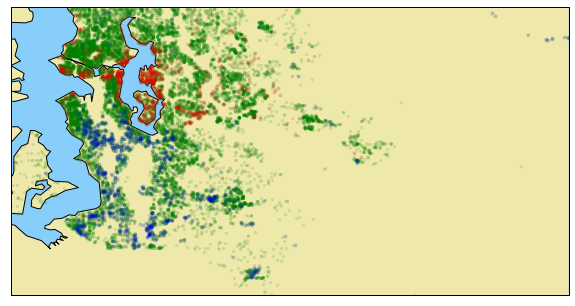

In [0]:
# 03.4 Maps

dataset_map = dataset_all.toPandas()

# Selection of the most expensive houses
dataset_map = dataset_map.sort_values(by='price', ascending=False)
dataset_expensive = dataset_map[0:1000]

# Selection of the cheapest houses
dataset_map = dataset_map.sort_values(by='price', ascending=True)
dataset_cheap = dataset_map[0:1000]


lat1, lat2 = dataset_map['lat'].min(), dataset_map['lat'].max()
long1, long2 = dataset_map['long'].min(), dataset_map['long'].max()

plt.figure(figsize=(10, 10))
m = Basemap(projection='cyl', resolution='h',
            llcrnrlat=lat1, urcrnrlat=lat2,
            llcrnrlon=long1, urcrnrlon=long2)

m.drawcoastlines()
m.fillcontinents(color='palegoldenrod', lake_color='lightskyblue')
m.drawmapboundary(fill_color='lightskyblue')

m.scatter(dataset_map['long'], dataset_map['lat'], s=5, c='green', alpha=0.1, zorder=2)
m.scatter(dataset_expensive['long'], dataset_expensive['lat'], s=10, c='red', alpha=0.1, zorder=4)
m.scatter(dataset_cheap['long'], dataset_cheap['lat'], s=10, c='blue', alpha=0.1, zorder=3)

plt.show()

To analyze the map, all the property locations were printed out. <br/>
Analyzing only by numbers, zipcode, latitude and longitude had poor correlation results in the correlation matrix. <br/>
To better understand whether location correlates with price, a second printing was made on the map, highlighting the most expensive and cheapest houses. <br/>
The results were very interesting, showing that the most expensive and cheapest houses are not mixed together, but in different regions. So, creating another column adding neighborhood could add great value to the model.

### 04. Modeling and Evaluation

In [0]:
# 04.1 Adding a vector assembler
# filtered_columns_02 = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15']

assembler = VectorAssembler(inputCols=['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 
                                       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'], outputCol='features')

data_final = assembler.transform(dataset_filter_01)
data_final.show(3)
data_final.printSchema()

+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+--------------------+
|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|            features|
+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+--------------------+
|221900.0|       3|      1.0|       1180|    5650|   1.0|         0|   0|        3|    7|      1180|            0|    1955|           0|  98178|47.5112|-122.257|         1340|      5650|[3.0,1.0,1180.0,5...|
|538000.0|       3|     2.25|       2570|    7242|   2.0|         0|   0|        3|    7|      2170|          400|    1951|        1991|  98125| 47.721|-122.319|       

In [0]:
# 4.2. StandardScaler
scaler_model = StandardScaler_01(inputCol='features', outputCol='scaledFeatures').fit(data_final)
data_final = scaler_model.transform(data_final)
data_final.show(3)

+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+--------------------+--------------------+
|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|            features|      scaledFeatures|
+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+--------------------+--------------------+
|221900.0|       3|      1.0|       1180|    5650|   1.0|         0|   0|        3|    7|      1180|            0|    1955|           0|  98178|47.5112|-122.257|         1340|      5650|[3.0,1.0,1180.0,5...|[3.22559199779093...|
|538000.0|       3|     2.25|       2570|    7242|   2.0|         0|   0|        3| 

In [0]:
# 04.3. Linear Regression (Test 01)

# 4.3.1. Restructuring between predictor and target attributes
linear_regression_data = data_final.select(['scaledFeatures', 'price'])

# 4.3.2. Dividing the sample
train_data, test_data = linear_regression_data.randomSplit([0.7, 0.3])

# 4.3.3. Building a Linear Regression Model object
model_lr = LinearRegression_01(featuresCol='scaledFeatures', labelCol='price', predictionCol='prediction')
trained_model = model_lr.fit(train_data)

# 4.3.4. Checking the efficiency of the model
test_predictions = trained_model.evaluate(test_data)

test_predictions.r2 # R: 0.7043

test_predictions.meanAbsoluteError # (MAE) R: 125290.0567
test_predictions.meanSquaredError # (MSE) R: 39641517794.3061
test_predictions.rootMeanSquaredError # (RMSE) R: 199101.7774

# 4.3.5. Using the model and creating predictions
unlabeled_data = test_data.select('scaledFeatures')
prediction_linear = trained_model.transform(unlabeled_data)

In [0]:
# 04.4. Linear Regression, y treated (Test 02):

# 4.4.1. Restructuring between predictor and target attributes
X = df.iloc[:, 1:].values # atributos previsores
y = df.iloc[:, 0].values # atributos-alvo respostas

# 4.4.2. Scale and Normalizing 
scaler = StandardScaler_02()
X = scaler.fit_transform(X)
y_dif = np.log(y)

# 4.4.3. Dividing the sample
X_treinamento, X_teste, y_dif_treinamento, y_dif_teste = train_test_split(X, y_dif, test_size = 0.2)

# 4.4.4. Building a Linear Regression Model object
model_lr_treated = LinearRegression_02()
model_lr_treated.fit(X_treinamento, y_dif_treinamento)

# 4.4.5. Checking the efficiency of the model
model_lr_treated.score(X_treinamento, y_dif_treinamento) # R: 0.7713
model_lr_treated.score(X_teste, y_dif_teste) # R: 0.7609

prev_lr = model_lr_treated.predict(X_teste)
acerto_linear_regression_treated = metrics.r2_score(y_dif_teste, prev_lr) # R: 0.7609

mean_absolute_error(y_dif_teste, prev_lr) # (MAE) R: 0.1986
mean_squared_error(y_dif_teste, prev_lr) # (MSE) R: 0.0659
math.sqrt(mean_squared_error(y_dif_teste, prev_lr)) # (RMSE) R: 0.2567


Out[41]: 0.24766603713584112

In [0]:
# 04.5. Gaussian Naive Bayes Model (Test 03):

# 4.5.1. Restructuring between predictor and target attributes
X = df.iloc[:, 1:].values # atributos previsores
y = df.iloc[:, 0].values # atributos-alvo respostas

# 4.5.2. Scale
scaler = StandardScaler_02()
X = scaler.fit_transform(X)

# 4.5.3. Dividing the sample
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X, y, test_size=0.2)

# 4.5.4. Building a Gaussian NB Model object
model_gauss = GaussianNB()
model_gauss.fit(X_treinamento, y_treinamento)

# 4.5.5. Checking the efficiency of the model
model_gauss.score(X_treinamento, y_treinamento) # R: 0.1616
model_gauss.score(X_teste, y_teste) # R: 0.0

prev_gauss = model_gauss.predict(X_teste)
acerto_gaussnb = metrics.r2_score(y_teste, prev_gauss)
print(acerto_gaussnb) # R: 0.5066

mean_absolute_error(y_teste, prev_gauss) # (MAE) R:162815.5725
mean_squared_error(y_teste, prev_gauss) # (MSE) R: 71248962347.7094
math.sqrt(mean_squared_error(y_teste, prev_gauss)) # (RMSE) R: 266925.0125

0.5106670527731496
Out[42]: 268743.43188904406

In [0]:
# 04.6. Random Forest (Test 04):

# 4.6.1. Restructuring between predictor and target attributes
X = df.iloc[:, 1:].values # atributos previsores
y = df.iloc[:, 0].values # atributos-alvo respostas

# 4.6.2. Scale
scaler = StandardScaler_02()
X = scaler.fit_transform(X)

# 4.6.3. Dividing the sample
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X, y, test_size=0.2)

# 4.6.4. Building a Random Forest Model object
model_random_forest = RandomForestRegressor(n_estimators = 100, random_state = 0)
model_random_forest.fit(X_treinamento, y_treinamento)

# 4.6.5. Checking the efficiency of the model
model_random_forest.score(X_treinamento, y_treinamento) # R: 0.9796
model_random_forest.score(X_teste, y_teste) # R: 0.8589

prev_random_forest = model_random_forest.predict(X_teste)
acerto_random_forest = metrics.r2_score(y_teste, prev_random_forest)
print(acerto_random_forest) # R: 0.8589

mean_absolute_error(y_teste, prev_random_forest) # (MAE) R: 74376.3150
mean_squared_error(y_teste, prev_random_forest) # (MSE) R: 18145867359.2273
math.sqrt(mean_squared_error(y_teste, prev_random_forest)) # (RMSE) R: 134706.5973

0.8619446194522784
Out[43]: 137021.7262093506

In [0]:
# 04.7. Decision Tree Model (Test 05):

# 4.7.1. Restructuring between predictor and target attributes
X = df.iloc[:, 1:].values # atributos previsores
y = df.iloc[:, 0].values # atributos-alvo respostas

# 4.7.2. Scale
scaler = StandardScaler_02()
X = scaler.fit_transform(X)

# 4.7.3. Dividing the sample
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X, y, test_size=0.2)

# 4.7.4. Building a Decision Tree Model object
model_decision_tree = DecisionTreeRegressor()  
model_decision_tree.fit(X_treinamento, y_treinamento)

# 4.7.5. Checking the efficiency of the model
model_decision_tree.score(X_treinamento, y_treinamento) # R:0.9993
model_decision_tree.score(X_teste, y_teste) # R: 0.6968

prev_dec_tree = model_decision_tree.predict(X_teste)
acerto_dec_tree = metrics.r2_score(y_teste, prev_dec_tree)
print(acerto_dec_tree) # R: 0.6968

mean_absolute_error(y_teste, prev_dec_tree) # (MAE) R: 103371.8910
mean_squared_error(y_teste, prev_dec_tree) # (MSE) R:37149645350.9222
math.sqrt(mean_squared_error(y_teste, prev_dec_tree)) # (RMSE) R:192742.4326

0.7178934886943873
Out[44]: 193253.4437372694

In [0]:
# 04.8. SVM Support Vector Machine (Test 06):

# 4.8.1. Restructuring between predictor and target attributes
X = df.iloc[:, 1:].values # atributos previsores
y = df.iloc[:, 0].values # atributos-alvo respostas

# 4.8.2. Scale
scaler = StandardScaler_02()
X = scaler.fit_transform(X)

# 4.8.3. Dividing the sample
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X, y, test_size=0.2)

# 4.8.4. Building a SVM Model object
model_svm = SVR()
model_svm.fit(X_treinamento, y_treinamento)

# 4.8.5. Checking the efficiency of the model
model_svm.score(X_treinamento, y_treinamento) # R: -0.0568
model_svm.score(X_teste, y_teste) # R: -0.0578

prev_svm = model_svm.predict(X_teste)
acerto_dec_tree = metrics.r2_score(y_teste, prev_svm)
print(acerto_dec_tree) # R: -0.0578

mean_absolute_error(y_teste, prev_svm) # (MAE) R: 219945.6872
mean_squared_error(y_teste, prev_svm) # (MSE) R: 131568942075.9466
math.sqrt(mean_squared_error(y_teste, prev_svm)) # (RMSE) R: 362724.3334

-0.050501096791728095
Out[45]: 376815.16249232274

In [0]:
# 04.9. CatBoost Model (Test 07):

# 4.6.1. Restructuring between predictor and target attributes
X = df.iloc[:, 1:].values # atributos previsores 
y = df.iloc[:, 0].values # atributos-alvo respostas
'''
# 4.9.2. Scale and Normalizing 
scaler = StandardScaler_02()
X = scaler.fit_transform(X)
y = np.log(y)

# 4.9.3. New selection of predictor attributes
selecao = SelectFdr(f_regression, alpha=0.00)
X_novo = selecao.fit_transform(X, y)

# 4.9.4. Dividing the sample
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X_novo, y, test_size = 0.2, random_state = 1)
'''
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X, y, test_size=0.2)

# 4.9.5. Building CatBoost Model object
model_catboost = ctb.CatBoostRegressor()
model_catboost.fit(X_treinamento, y_treinamento)

# 4.9.6. Checking the efficiency of the model
model_catboost.score(X_treinamento, y_treinamento) # R: 0.9607
model_catboost.score(X_teste, y_teste) # R: 0.8881

prev_catboost = model_catboost.predict(X_teste)
acerto_class_normal = metrics.r2_score(y_teste, prev_catboost)
print(acerto_class_normal) # R: 0.8881

mean_absolute_error(y_teste, prev_catboost) # (MAE) R: 63965.4726
mean_squared_error(y_teste, prev_catboost) # (MSE) R: 14495239743.1262
math.sqrt(mean_squared_error(y_teste, prev_catboost)) # (RMSE) R: 120396.1782

Learning rate set to 0.064232
0:	learn: 351877.1228471	total: 6.51ms	remaining: 6.5s
1:	learn: 337725.5181357	total: 12.3ms	remaining: 6.15s
2:	learn: 324554.6456650	total: 18ms	remaining: 5.97s
3:	learn: 312393.4264105	total: 24.3ms	remaining: 6.05s
4:	learn: 301732.8508454	total: 35.1ms	remaining: 6.98s
5:	learn: 291333.8171375	total: 47.1ms	remaining: 7.8s
6:	learn: 281741.7768348	total: 52.7ms	remaining: 7.48s
7:	learn: 272436.8881481	total: 58.4ms	remaining: 7.24s
8:	learn: 264543.4727778	total: 64.9ms	remaining: 7.14s
9:	learn: 256583.6356586	total: 70.8ms	remaining: 7.01s
10:	learn: 248744.1607119	total: 76.4ms	remaining: 6.87s
11:	learn: 241749.0962180	total: 81.9ms	remaining: 6.74s
12:	learn: 235605.6794620	total: 87.4ms	remaining: 6.64s
13:	learn: 229733.1289415	total: 93.1ms	remaining: 6.56s
14:	learn: 223836.9457139	total: 98.6ms	remaining: 6.47s
15:	learn: 217555.3629707	total: 104ms	remaining: 6.41s
16:	learn: 212401.2769921	total: 110ms	remaining: 6.34s
17:	learn: 207856

In [0]:
# 04.10. Extreme Gradient Boosting (Test 08):

# 4.10.1. Restructuring between predictor and target attributes
X = df.iloc[:, 1:].values # atributos previsores 
y = df.iloc[:, 0].values # atributos-alvo respostas
'''
# 4.10.2. Scale and Normalizing 
scaler = StandardScaler_02()
X = scaler.fit_transform(X)
y = np.log(y)

# 4.10.3. New selection of predictor attributes
selecao = SelectFdr(f_regression, alpha=0.00) # chi2, alpha=0.01
X_novo = selecao.fit_transform(X, y)

# 4.10.4. Dividing the sample
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X_novo, y, test_size = 0.2, random_state = 1)
'''
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X, y, test_size=0.2)

# 4.10.5. Building XGB Model object
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_treinamento, y_treinamento)

# 4.10.6. Checking the efficiency of the model
model_xgb.score(X_treinamento, y_treinamento) # R: 0.9738
model_xgb.score(X_teste, y_teste) # R: 0.8894

prev_xgb = model_xgb.predict(X_teste)
acerto_class_normal = metrics.r2_score(y_teste, prev_xgb)
print(acerto_class_normal) # R: 0.8894

mean_absolute_error(y_teste, prev_xgb) # (MAE) R: 69339.4134
mean_squared_error(y_teste, prev_xgb) # (MSE) R: 14759663537.4347
math.sqrt(mean_squared_error(y_teste, prev_xgb)) # (RMSE) R: 121489.3556

0.8763380202338606
Out[47]: 122574.07133850796

The ML models with the best performance were Random Forest, Decision Tree, CatBoost and Extreme Gradient Boots, which achieved excellent scores. <br/>
New tests will then be performed using them to understand which is the best and if reducing the number of predictor attributes can affect the efficiency of the code. Attribute selection techniques such as Chi Square and regression were used.


In [0]:
# 04.11. Final performance test:

# 4.11.1. Restructuring between predictor and target attributes
X = df.iloc[:, 1:].values # atributos previsores 
y = df.iloc[:, 0].values # atributos-alvo respostas
'''
# 4.11.2. New selection of predictor attributes
selection = SelectFdr(f_regression, alpha=0.00)
X_novo = selection.fit_transform(X, y)
# X.shape, X_novo.shape, 
# Selection results:
# ((21613, 18), (21613, 18)) With: f_regression, alpha=0.01
# ((21613, 18), (21613, 10)) With: f_regression, alpha=0.00
# ((21613, 17), (21613, 9)) With: chi2, alpha=0.01 
# ((21613, 17), (21613, 8)) With: chi2, alpha=0.00 
'''
# 4.11.3. Building all model objects
resultados_random_forest_cv = []
resultados_decision_tree_cv = []
resultados_catboost_cv = []
resultados_xgb_cv = []

for i in range(10):
    X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X, y, test_size=0.2)

    model_random_forest = RandomForestRegressor(n_estimators = 100, random_state = 0)
    model_random_forest.fit(X_treinamento, y_treinamento)
    resultados_random_forest_cv.append(metrics.r2_score(y_teste, model_random_forest.predict(X_teste)))

    model_decision_tree = DecisionTreeRegressor()
    model_decision_tree.fit(X_treinamento, y_treinamento)
    resultados_decision_tree_cv.append(metrics.r2_score(y_teste, model_decision_tree.predict(X_teste)))

    model_catboost = ctb.CatBoostRegressor()
    model_catboost.fit(X_treinamento, y_treinamento)
    resultados_catboost_cv.append(metrics.r2_score(y_teste, model_catboost.predict(X_teste)))

    model_xgb = xgb.XGBRegressor()
    model_xgb.fit(X_treinamento, y_treinamento)
    resultados_xgb_cv.append(metrics.r2_score(y_teste, model_xgb.predict(X_teste)))

resultados_random_forest_cv = np.array(resultados_random_forest_cv)
resultados_decision_tree_cv = np.array(resultados_decision_tree_cv)
resultados_catboost_cv = np.array(resultados_catboost_cv)
resultados_xgb_cv = np.array(resultados_xgb_cv)

# 4.11.4. Checking the efficiency of all models 
resultados_random_forest_cv.mean(), resultados_decision_tree_cv.mean(), resultados_catboost_cv.mean(), resultados_xgb_cv.mean()
# Results:
# [0.8761, 0.7323, 0.9060, 0.8884] With no selection, columns: (21613, 14)
# [0.8736, 0.7447, 0.9038, 0.8780] With: f_regression, alpha=0.01, columns: (21613, 14)
# [0.8074, 0.6046, 0.8250, 0.8013] With: f_regression, alpha=0.00, columns: (21613, 10)
# [0.6678, 0.3662, 0.6735, 0.6423] With: chi2, alpha=0.01, columns: (21613, 9)
# [0.6507, 0.3341, 0.6537, 0.6183] With: chi2, alpha=0.00, columns: (21613, 8)

[[resultados_random_forest_cv.min(),resultados_random_forest_cv.max()],
[resultados_decision_tree_cv.min(),resultados_decision_tree_cv.max()],
[resultados_catboost_cv.min(),resultados_catboost_cv.max()],
[resultados_xgb_cv.min(),resultados_xgb_cv.max()]]

# Results:
# [[0.8493, 0.8988], [0.6813, 0.7914], [0.8860, 0.9204], [0.8650, 0.9098]] With no selection, columns: (21613, 14)
# [[0.8539, 0.8904], [0.6809, 0.7755], [0.8932, 0.9129], [0.8584, 0.8870]] With: f_regression, alpha=0.01, columns: (21613, 14)
# [[0.7526, 0.8405], [0.5199, 0.6785], [0.7935, 0.8475], [0.7527, 0.8434]] With: f_regression, alpha=0.00, columns: (21613, 10)
# [[0.6155, 0.7036], [0.2757, 0.4496], [0.6271, 0.7063], [0.6023, 0.6886]] With: chi2, alpha=0.01, columns: (21613, 9)
# [[0.6229, 0.6928], [0.2727, 0.4296], [0.6354, 0.6831], [0.5892, 0.6516]] With: chi2, alpha=0.00, columns: (21613, 8)

Learning rate set to 0.064232
0:	learn: 348811.2314045	total: 6.44ms	remaining: 6.43s
1:	learn: 334696.9572845	total: 12.5ms	remaining: 6.22s
2:	learn: 321533.4126333	total: 18.2ms	remaining: 6.05s
3:	learn: 309259.3742612	total: 24.2ms	remaining: 6.03s
4:	learn: 298217.0230420	total: 30ms	remaining: 5.97s
5:	learn: 287646.7063328	total: 35.9ms	remaining: 5.94s
6:	learn: 278203.0272622	total: 42ms	remaining: 5.96s
7:	learn: 269408.4190511	total: 48.2ms	remaining: 5.98s
8:	learn: 260995.7284174	total: 54.1ms	remaining: 5.96s
9:	learn: 252875.2429400	total: 60ms	remaining: 5.94s
10:	learn: 245449.5946440	total: 65.9ms	remaining: 5.92s
11:	learn: 238256.5899146	total: 71.7ms	remaining: 5.91s
12:	learn: 231506.2817125	total: 79.5ms	remaining: 6.03s
13:	learn: 225334.8087992	total: 85.3ms	remaining: 6.01s
14:	learn: 219427.3518394	total: 91.4ms	remaining: 6s
15:	learn: 214115.2538503	total: 97.3ms	remaining: 5.98s
16:	learn: 209079.5636414	total: 103ms	remaining: 5.96s
17:	learn: 204109.482

### 05. Discussion and Conclusion
According to the results of the models, the algorithm that gave the best result compared to the other algorithms was CatBoost. <br/>
The models were evaluated with and without data selection and normalization and according to the results, selection and normalization contributed negatively to the model's performance.<br/>
We can see that the model isn't perfect ("perfect" doesn't exist), but I understand that it worked, with an accuracy of over 90%<br/>
Therefore, CatBoost was chosen to best perform the pricing of property values.

Thank you for following up here and if you have any suggestions or constructive criticism, I'm 100% open!

**Joao Ambrosio**